# Лабораторная №6. Выбор признаков

Выполнил: Подцепко Игорь Сергеевич, учебная группа M33351

## Реализация методов выбора признаков

Я выбрал следующие методы выбора признаков:
1. RFE (SVM-RFE) в качестве _внутреннего_;
2. SFS (sequential feature selection) в качестве _метода-обертки_ (forward модификацию);
3. Одномерный фильтрующий метод на основе $\chi^2$.

Реализации их вынесены в отдельный пакет `implementation`, чтобы не засорять ноутбук (см. `./implementation/_rfe.py`, `./implementation/_sequential_feature_selector.py` и `./implementation/_filters.py`).

## Применение реализованных методов

В качестве "подопытного" набора данных я выбрал SMS. В силу того, что текст - это неструктурированные данные, необходимо выполнить предварительную обработку: очистку и векторизацию.

In [1]:
import pandas as pd

df = pd.read_table("./SMS.tsv")
df.head()

,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [2]:
import nltk

nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt")
nltk.download('omw-1.4');

[nltk_data] Downloading package stopwords to /home/igor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/igor/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/igor/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/igor/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Выполним очистку текста:
1. Приведем все символы к нижнему регистру;
2. Удалим стоп-слова, так как они обычно не несут полезной информации;
3. Оставим только слова, состоящие из букв
4. Выполним лемматизацию - приведение слов в тексте к их базовым формам, чтобы объединить разные формы одного и того же слова в единый признак.

In [3]:
def clear_message(text: str) -> str:
    stop_words = set(nltk.corpus.stopwords.words("english"))
    lemmatizer = nltk.stem.WordNetLemmatizer()
    words = [
        lemmatizer.lemmatize(word)
        for word in nltk.tokenize.word_tokenize(text.lower())
        if word not in stop_words and word.isalpha()
    ]
    return " ".join(words)


df.text = df.text.apply(clear_message)
df.head()

,class,text
0,ham,go jurong point crazy available bugis n great ...
1,ham,ok lar joking wif u oni
2,spam,free entry wkly comp win fa cup final tkts may...
3,ham,u dun say early hor u c already say
4,ham,nah think go usf life around though


Применим алгорим TF-IDF для векторизации сообщений (предлагался к использованию в чате курса):

In [4]:
import random
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df.text)
y = df["class"].replace({"ham": 0, "spam": 1}).to_numpy()

feature_names = vectorizer.get_feature_names_out()  # dict with words


def get_selected_words(selected):
    return [feature_names[word_index] for (word_index, is_selected) in enumerate(selected) if is_selected]


print(random.sample(sorted(feature_names), 10))

['settling', 'mile', 'themed', 'told', 'easter', 'consent', 'sic', 'tough', 'jaklin', 'jetton']


Сразу разделим набор данных на тренировочную (80%) и тестовую (20%) части.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

Для применения RFE требуется классификатор. В модификации SVM-RFE - это классификатор на основе SVM. Именно его коэффициенты используются для определения важности признаков. Чтобы улучшить качество работы RFE - быстро найдем более-менее адекватные параметры для модели `sklearn.svm.SVC` (я не уделял этому особого внимания, так как данный пункт не относится к основной цели лабораторной работы).

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm

param_grid = {
    "C": [0.1, 1, 10, 100],
    "gamma": [1, 0.1, 0.01, 0.001],
    "kernel": ["linear"],
}

grid = GridSearchCV(svm.SVC(), param_grid, refit=True, verbose=1)
grid.fit(X_train, y_train);

Fitting 5 folds for each of 16 candidates, totalling 80 fits


### Применение метода SVN-RFE

In [7]:
from implementation import RFE
from pprint import pprint

svc_estimator = svm.SVC(**grid.best_params_)
rfe = RFE(estimator=svc_estimator, n_features_to_select=30, step=200).fit(X_train, y_train)
rfe_selected_words = get_selected_words(rfe.get_selected())
pprint(rfe_selected_words)

100%|██████████| 34/34 [00:09<00:00,  3.49it/s]

['ac',
 'alert',
 'apply',
 'awarded',
 'claim',
 'collection',
 'eg',
 'freemsg',
 'ldn',
 'linerental',
 'mobile',
 'morning',
 'network',
 'opt',
 'orange',
 'pobox',
 'prize',
 'rate',
 'ringtone',
 'sae',
 'service',
 'suprman',
 'tone',
 'txt',
 'txts',
 'unsubscribe',
 'vodafone',
 'voucher',
 'wap',
 'win']


По-моему, результат частично ожидаем. Например, кажется очевидным, что слова "awarded", "prize", "win" могут намекать на то, что сообщение является спамом. А "unsubscribe" - это кнопка, которая почти всегда находится внизу надоедливых сообщений (рекламных/новостных рассылок) почти любых сервисов: twitter, hh.ru и др.

### Применение SFS (sequential feature selection)

In [8]:
from implementation import SFS

sfs = SFS(estimator=svc_estimator, n_features_to_select=30).fit(X_train, y_train, X_test=X_test, y_test=y_test)
sfs_selected_words = get_selected_words(sfs.get_selected())
pprint(sfs_selected_words)

100%|██████████| 30/30 [36:23<00:00, 72.77s/it]

['access',
 'admirer',
 'auction',
 'await',
 'bak',
 'bluetooth',
 'box',
 'claim',
 'club',
 'co',
 'dogging',
 'entry',
 'hmv',
 'http',
 'incredible',
 'landline',
 'ldn',
 'mobile',
 'opt',
 'pobox',
 'poly',
 'polys',
 'private',
 'prize',
 'service',
 'std',
 'textoperator',
 'txt',
 'urgent',
 'video']


В данном случае метод отобрал несколько иные слова, однако, например, "prize" всё еще присутствует среди отобранных слов. Стоит отметить, что в данном наборе данных после векторизации всего более 6500 слов, так что совпадение хотя бы одного в результирующем списке уже говорит о том, что направления, в котором происходит отбор, достаточно близкие. И это не единственное слово, относительно важности которого SFS оказался согласен с SVM-RFE.

Примечательно здесь, по-моему, еще слово "http". Скорее всего его присутствие сообщает нам о наличии ссылок в сообщении - это может быть характерно для спама.

### Применение фильтрующего метода на основе $\chi^2$

In [9]:
from implementation import Chi2Filter

chi2 = Chi2Filter(n_features_to_select=30).fit(X_train.toarray(), y_train)
chi2_selected_words = get_selected_words(chi2.get_selected())
pprint(chi2_selected_words)

['award',
 'awarded',
 'call',
 'camera',
 'cash',
 'claim',
 'contact',
 'customer',
 'draw',
 'free',
 'guaranteed',
 'landline',
 'mobile',
 'nokia',
 'per',
 'prize',
 'rate',
 'reply',
 'ringtone',
 'service',
 'stop',
 'text',
 'tone',
 'txt',
 'urgent',
 'valid',
 'video',
 'voucher',
 'weekly',
 'win']


Здесь снова можно увидеть "price" и "win". Еще из интересного - "cash", "free". Теперь посмотрим в чем вышеперечисленные методы "согласны":

In [10]:
consensus = set.intersection(set(rfe_selected_words), set(sfs_selected_words), set(chi2_selected_words))
print(f"{len(consensus)}: {consensus}")

5: {'mobile', 'prize', 'txt', 'service', 'claim'}


Таким образом, 5 данных слов присутствуют в списках для каждого из вышеперечисленных методов.

## Применение библиотечных методов

### Внутренний метод `SelectFromModel` на базе дерева принятия решений

In [11]:
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()
tree_selector = SelectFromModel(estimator=tree, max_features=30).fit(X_train, y_train)
selected_from_tree_words = get_selected_words(tree_selector.get_support())
pprint(selected_from_tree_words)

['call',
 'claim',
 'come',
 'coming',
 'contact',
 'free',
 'get',
 'give',
 'hi',
 'http',
 'landline',
 'later',
 'lt',
 'maximize',
 'mobile',
 'new',
 'nokia',
 'rate',
 'rcvd',
 'reply',
 'ringtone',
 'service',
 'stop',
 'text',
 'tone',
 'txt',
 'urgent',
 'video',
 'voucher',
 'wap']


### Фильтрующий метод `SelectKBest` на основе F-статистики

In [12]:
from sklearn.feature_selection import SelectKBest, f_classif

f_classifier = SelectKBest(score_func=f_classif, k=30).fit(X.toarray(), y)
f_classifier_selected_words = get_selected_words(f_classifier.get_support())
pprint(f_classifier_selected_words)

['apply',
 'awarded',
 'call',
 'cash',
 'claim',
 'code',
 'collection',
 'contact',
 'customer',
 'draw',
 'free',
 'guaranteed',
 'landline',
 'latest',
 'line',
 'mobile',
 'nokia',
 'per',
 'prize',
 'rate',
 'reply',
 'ringtone',
 'service',
 'stop',
 'text',
 'tone',
 'txt',
 'urgent',
 'voucher',
 'win']


### Фильтрующий метод `SelectKBest` на основе оценки взаимной информации

In [13]:
from sklearn.feature_selection import mutual_info_classif

mutual_info_classifier = SelectKBest(score_func=mutual_info_classif, k=30).fit(X.toarray(), y)
mutual_info_classifier_selected_words = get_selected_words(mutual_info_classifier.get_support())
pprint(mutual_info_classifier_selected_words)

['asthma',
 'call',
 'cash',
 'claim',
 'conected',
 'dirtiest',
 'draw',
 'facebook',
 'free',
 'glorious',
 'guaranteed',
 'holder',
 'landline',
 'latest',
 'mobile',
 'per',
 'prize',
 'rate',
 'reply',
 'send',
 'service',
 'stop',
 'tescos',
 'text',
 'today',
 'tone',
 'txt',
 'urgent',
 'voucher',
 'win']


Хочу пояснить выбор методов: методы-обертки работают крайне долго, поэтому хотелось все-таки остановиться на чем-то другом. Скорость работы фильтрующих методов на высоте, так что остановился я именно на них.

In [14]:
consensus = set.intersection(set(selected_from_tree_words), set(f_classifier_selected_words),
                             set(mutual_info_classifier_selected_words))
print(f"{len(consensus)}: {consensus}")

14: {'urgent', 'mobile', 'free', 'text', 'voucher', 'txt', 'stop', 'service', 'reply', 'call', 'claim', 'landline', 'tone', 'rate'}


Среди слов, выбранных всеми вручную реализованными методами, "mobile", "txt", "service" "claim" были выбраны также и всеми библиотечными методами. "prize" во второй список не попал.

## Сравнение качества работы до и после выбора признаков

Сравнение будем проводить на примере метода опорных векторов (`sklearn.svm.SVC`), дерева принятия решений (`sklearn.tree.DecisionTreeClassifier`) и наивного байесовского классификатора (`sklearn.naive_bayes.MultinomialNB`). Также (относительно формально) подберем какие-то гиперпараметры, которые подойдут для классификации этого набора данных.

In [20]:
from sklearn.naive_bayes import MultinomialNB

param_grid = {
    'alpha': [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 5.0, 10.0, 100.0],
    'fit_prior': [True, False]
}

grid_search = GridSearchCV(estimator=MultinomialNB(), param_grid=param_grid, verbose=1)
grid_search.fit(X_train, y_train)

naive_bayes_classifier = MultinomialNB(**grid_search.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


In [23]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid, verbose=1)
grid_search.fit(X, y)

decision_tree_classifier = DecisionTreeClassifier(**grid_search.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [73]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


def get_roc_auc_scores(classifier, train_features, train_labels, test_features, test_labels):
    classifier.fit(train_features, train_labels)
    prediction = classifier.predict(test_features)
    return roc_auc_score(test_labels, prediction)


def get_before_and_after(classifier, selector):
    return (get_roc_auc_scores(classifier, X_train, y_train, X_test, y_test),
            get_roc_auc_scores(classifier, selector.transform(X_train), y_train, selector.transform(X_test), y_test))


def test_feature_selector(feature_selector, classifiers=(
        (svc_estimator, "SVM"), (naive_bayes_classifier, "Bayes"), (decision_tree_classifier, "DT"))):
    fig, axs = plt.subplots(ncols=len(classifiers), sharey=True)
    axs[0].set_ylabel("score")
    for i, (classifier, name) in enumerate(classifiers):
        scores = get_before_and_after(classifier, feature_selector)
        axs[i].bar(["before", "after"], scores, color=["palegreen", "tomato"])
        for x, score in enumerate(scores):
            axs[i].text(x, score, str(round(score, 2)), ha='center', va='bottom')
        axs[i].set_title(name)
    plt.show()

### SVM-RFE

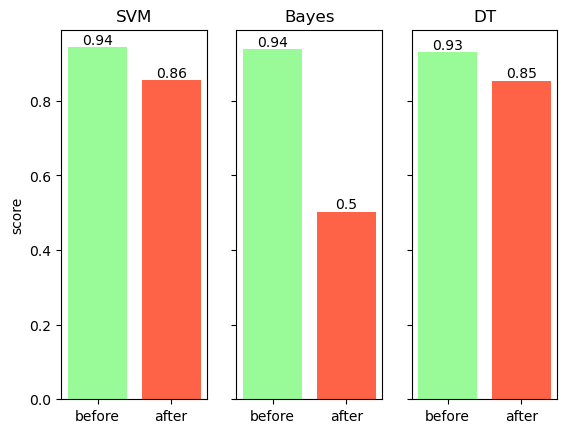

In [74]:
test_feature_selector(rfe)

### Sequential feature selection

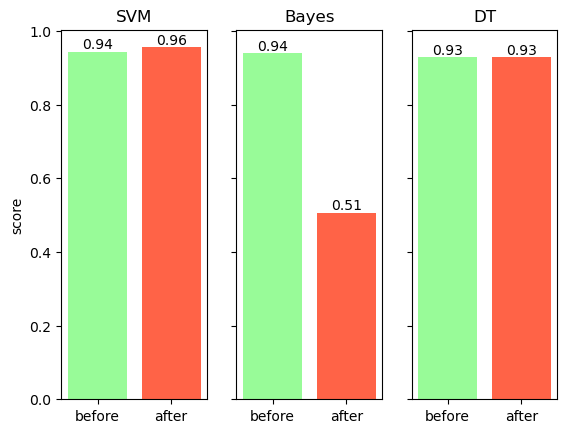

In [75]:
test_feature_selector(sfs)

### Фильтрующий метод на базе $\chi^2$

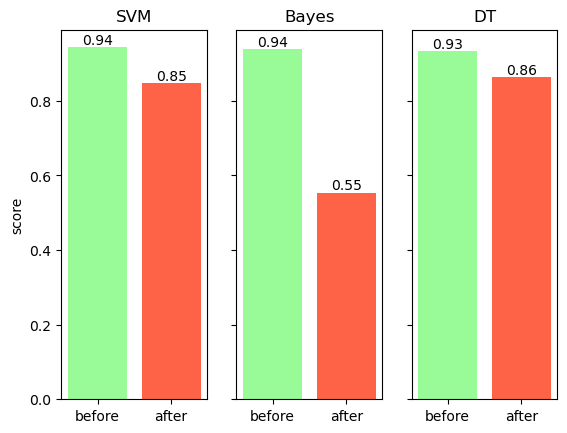

In [76]:
test_feature_selector(chi2)

### Внутренний метод `SelectFromModel` на базе дерева принятия решений

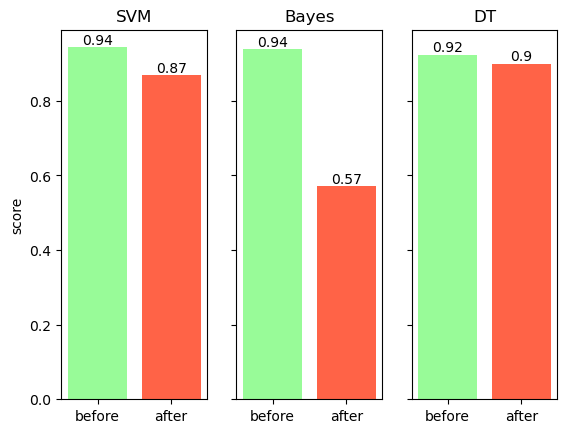

In [77]:
test_feature_selector(tree_selector)

### Фильтрующий метод `SelectKBest` на основе F-статистики

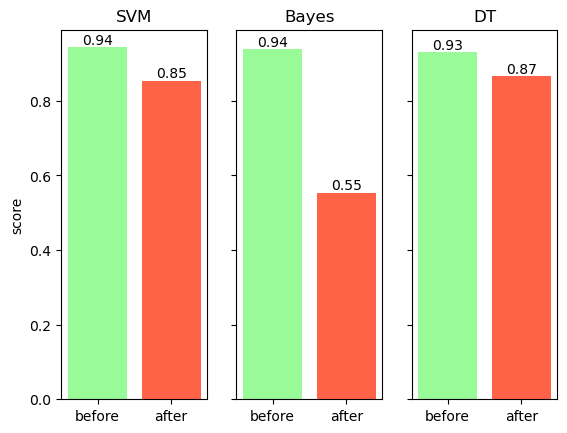

In [78]:
test_feature_selector(f_classifier)

### Фильтрующий метод `SelectKBest` на основе оценки взаимной информации

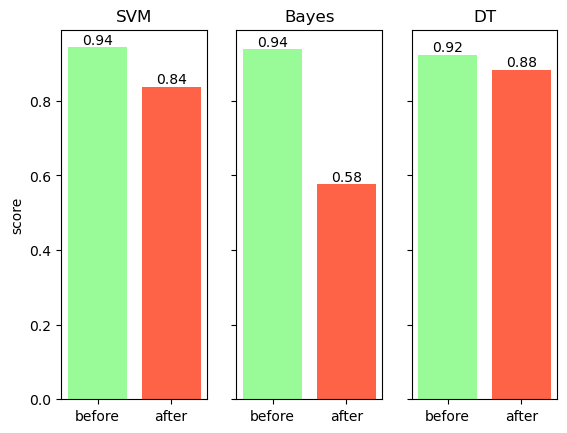

In [79]:
test_feature_selector(mutual_info_classifier)

**Вывод**: Selected feature selection оказался наиболее долгим методом (почти в 243 раза дольше, чем, например, SVM-RFE), однако проявил себя лучше всего при тестировании качества классификации методом опорных векторов и деревом принятия решений: он единственный, кто смог улучшить метрику ROC-AUC. Правда на наивном байесовском классификаторе результат ухудшился сильнее, чем при выборе признаков другими моделями.